<a href="https://colab.research.google.com/github/neha-369-tes/PRODIGY_DS_03/blob/main/PRODIGY_DS_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install category_encoders
!pip install plotly
!pip install tqdm
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm

In [44]:
data = pd.read_csv('/content/bank-additional-full.csv', sep=';')
display(data.head(3))
display('There is {} observations with {} features'.format(data.shape[0], data.shape[1]))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


'There is 41188 observations with 21 features'

In [45]:
def plot_bar(column):
    # temp df
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();


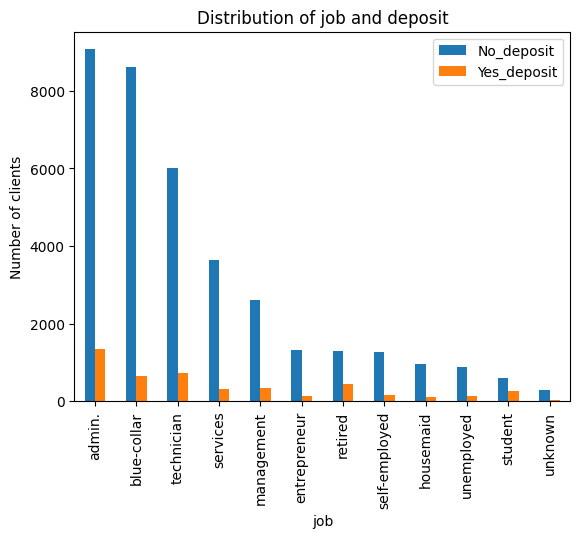

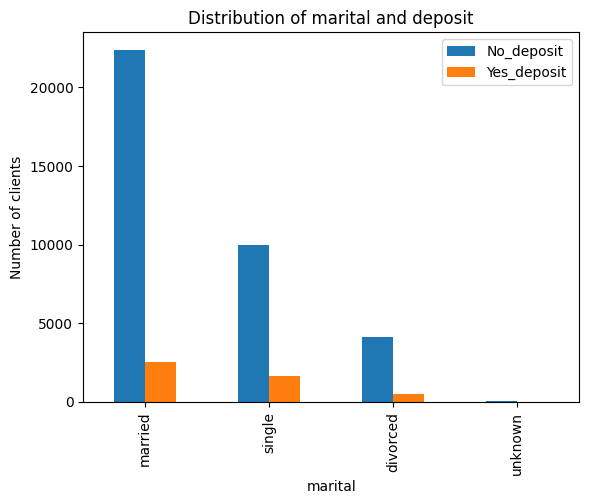

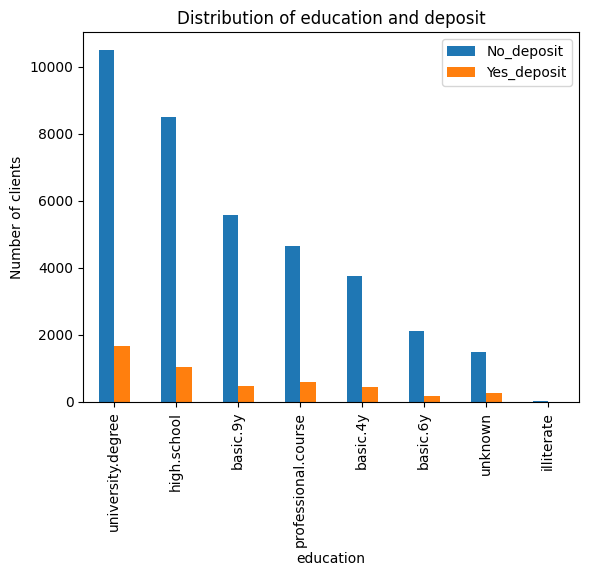

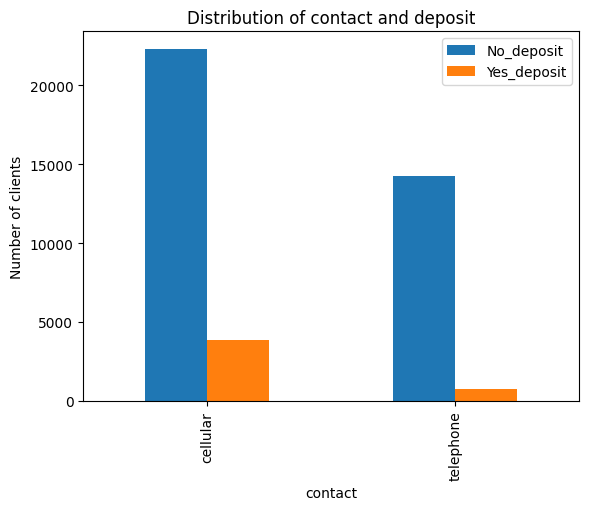

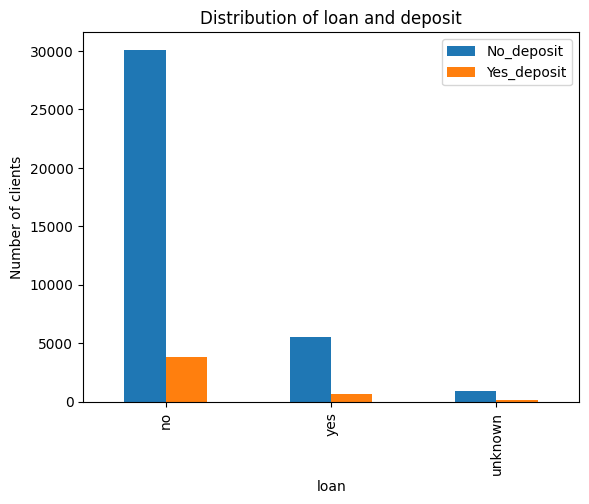

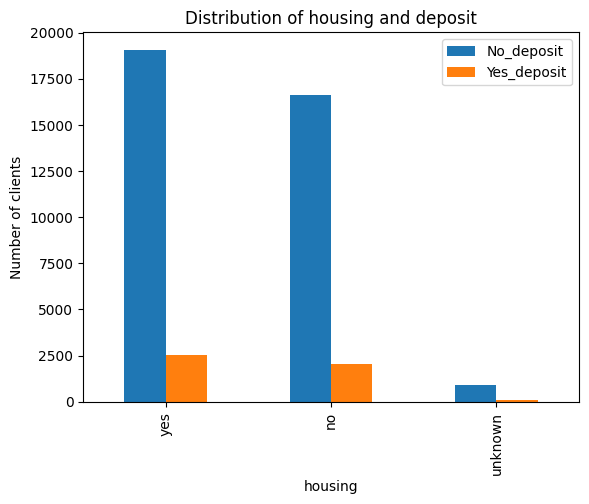

(None, None, None, None, None, None)

In [46]:
plot_bar('job'), plot_bar('marital'), plot_bar('education'), plot_bar('contact'), plot_bar('loan'), plot_bar('housing')

In [47]:
# Replace NaN values with a suitable value (e.g., -1) before converting to integer
data.y = data.y.map({'no':0, 'yes':1}).fillna(-1).astype('int8') # Changed 'uint8' to 'int8' to handle -1

In [48]:
# Convert 'job' and 'marital' columns to category codes
data['job'] = data['job'].astype('category').cat.codes
data['marital'] = data['marital'].astype('category').cat.codes
# Convert 'education' to category codes
data['education'] = data['education'].astype('category').cat.codes

# Calculate the correlation matrix
corr = data.corr(numeric_only = True)
corr.style.background_gradient(cmap='PuBu')

,age,job,marital,education,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.001250,-0.389753,-0.117892,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
job,0.001250,1.000000,0.027897,0.134121,-0.006490,-0.006923,-0.028468,0.020965,-0.008271,-0.016017,0.052760,-0.007880,-0.019574,0.025122
marital,-0.389753,0.027897,1.000000,0.109220,0.010290,-0.007240,-0.037942,0.038689,-0.084210,-0.057477,-0.033783,-0.091939,-0.086199,0.046203
education,-0.117892,0.134121,0.109220,1.000000,-0.015102,0.000371,-0.046626,0.038831,-0.043778,-0.081607,0.078799,-0.036380,-0.041492,0.057799
duration,-0.000866,-0.006490,0.010290,-0.015102,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.006923,-0.007240,0.000371,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.028468,-0.037942,-0.046626,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020965,0.038689,0.038831,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.008271,-0.084210,-0.043778,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,-0.016017,-0.057477,-0.081607,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211


In [49]:
# Replacing values with binary ()
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8')
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
data.pdays = data.pdays.replace(999, 0) # replace with 0 if not contact
data.previous = data.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') # binary has contact or not

# binary if were was an outcome of marketing campane
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8')

# change the range of Var Rate
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
data['emp.var.rate'] = data['emp.var.rate'] * -1
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# Multiply consumer index
data['cons.price.idx'] = (data['cons.price.idx'] * 10).astype('uint8')

# change the sign (we want all be positive values)
data['cons.conf.idx'] = data['cons.conf.idx'] * -1

# re-scale variables
data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')
data['cons.price.idx'] = np.log2(data['cons.price.idx']).astype('uint8')
data['cons.conf.idx'] = np.log2(data['cons.conf.idx']).astype('uint8')
data.age = np.log(data.age)

# less space
data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')
data.pdays = data.pdays.astype('uint8')

# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

# One Hot encoding of 3 variable
data = encode(data, data.job)
data = encode(data, data.month)
data = encode(data, data.day_of_week)

# Drop tranfromed features
data.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

In [50]:
data.drop_duplicates(inplace=True)

In [51]:
def duration(data):
    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration'] = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration'] = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 645), 'duration'] = 4
    data.loc[data['duration']  > 645, 'duration'] = 5
    return data
duration(data);

In [52]:
y = data.y
# Create target encoder object and transoform two value
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
# drop target variable
numeric_dataset.drop('y', axis=1, inplace=True)


In [53]:
display(numeric_dataset.head(3), numeric_dataset.shape, y.shape)
display('We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected')

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,4.025352,0.101565,0.102490,1,0,0,0,3,1,0,...,False,True,False,False,False,False,True,False,False,False
1,4.043051,0.101565,0.108389,0,0,0,0,2,1,0,...,False,True,False,False,False,False,True,False,False,False
2,3.610918,0.101565,0.108389,1,1,0,0,3,1,0,...,False,True,False,False,False,False,True,False,False,False


(41175, 44)

(41175,)

'We observe 41175 rows and 44 numerical features after transformation. Target variable shape is (41175, 0 ) as expected'

In [54]:
# set global random state
random_state = 11
# split data
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
# collect excess data
gc.collect()

17926

In [55]:
display('check the shape of splitted train and test sets', X_train.shape, y_train.shape, X_test.shape, y_test.shape)


'check the shape of splitted train and test sets'

(32940, 44)

(32940,)

(8235, 44)

(8235,)

In [56]:
# set all CPU
n_jobs = -1
# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])
# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='sqrt'))])
# BaggingClassifier
# note we use SGDClassifier as classier inside BaggingClassifier
pipe_bag = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),\
                                              random_state=random_state,oob_score=True,n_jobs=n_jobs))])
# SGDClassifier
pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])

In [57]:
# set number
'''Set parameters for Grid Search '''
# set number
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# set for RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# set for BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [10, 15, 20]}]

# set for SGDClassifier
grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'],
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]

In [58]:
# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv)
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)
# for SGDClassifier
gs_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,
                     scoring='accuracy', cv=cv)

In [59]:
# models that we iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag, gs_sgd]
# dict for later use
model_dict = {0:'Logistic_reg', 1:'RandomForest', 2:'Knn', 3:'DesionTree', 4:'Bagging with SGDClassifier', 5:'SGD Class'}

In [60]:
result_acc = {}
result_auc = {}
models = []

# Iterate over all models, including the SGDClassifier
for index, model in enumerate(look_for):
    if index not in model_dict:
        print(f"Skipping index {index} because it's not found in model_dict.")
        continue  # Skip undefined indices

    start = time.time()
    print()
    print('+++++++ Start New Model ++++++++++++++++++++++')
    print(f"Estimator is {model_dict[index]}")

    # Fit the model on training data
    model.fit(X_train, y_train)
    print('---------------------------------------------')
    print(f"best params {model.best_params_}")
    print(f"best score is {model.best_score_}")

    # AUC calculation: check if the model is an instance of SGDClassifier
    if isinstance(model.best_estimator_, SGDClassifier):
        # Handle the specific loss types for SGDClassifier
        loss_type = model.best_params_.get('sgd__loss', '')  # Ensure you fetch the correct key
        if loss_type in ['log_loss', 'modified_huber']:
            # Use predict_proba() for log_loss and modified_huber
            auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        else:
            # Use decision_function() for other loss types (e.g., hinge)
            auc = roc_auc_score(y_test, model.decision_function(X_test))
    else:
        # For all other classifiers, use predict_proba() to calculate AUC
        try:
            auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        except AttributeError:
            # Handle classifiers that do not have predict_proba method
            print(f"Skipping {model_dict[index]} (No predict_proba available)")
            continue

    # Print results
    print('---------------------------------------------')
    print(f"ROC_AUC is {auc} and accuracy rate is {model.score(X_test, y_test)}")
    end = time.time()
    print(f"It lasted for {round(end - start, 3)} sec")
    print('++++++++ End Model +++++++++++++++++++++++++++')
    print()

    # Store results for all models
    models.append(model.best_estimator_)
    result_acc[index] = model.best_score_
    result_auc[index] = auc



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic_reg
---------------------------------------------
best params {'lr__C': 0.6, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score is 0.9092592592592593
---------------------------------------------
ROC_AUC is 0.9216482278347329 and accuracy rate is 0.905525197328476
It lasted for 194.853 sec
++++++++ End Model +++++++++++++++++++++++++++


+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest
---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 70}
best score is 0.9035822707953857
---------------------------------------------
ROC_AUC is 0.926898425815701 and accuracy rate is 0.9038251366120219
It lasted for 95.811 sec
++++++++ End Model +++++++++++++++++++++++++++


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Knn
-----------------------------------------

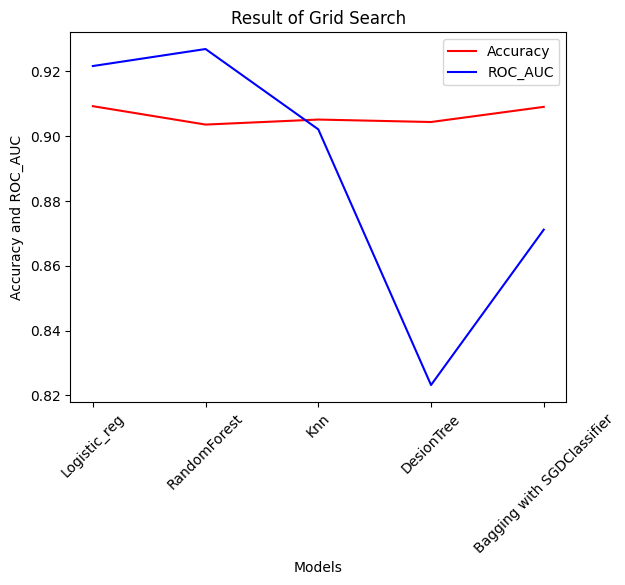

In [65]:
# Filter model_dict to only include models that have results
valid_indices = list(result_acc.keys())  # Only include models with results

# Get the corresponding model names from model_dict
valid_model_names = [model_dict[i] for i in valid_indices]

# Plotting
plt.plot(valid_model_names, [result_acc[i] for i in valid_indices], c='r')  # Accuracy
plt.plot(valid_model_names, [result_auc[i] for i in valid_indices], c='b')  # ROC_AUC

plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy and ROC_AUC')
plt.title('Result of Grid Search')
plt.legend(['Accuracy', 'ROC_AUC'])
plt.show()


In [66]:
""" Model performance during Grid Search """
pd.DataFrame(list(zip(model_dict.values(), result_acc.values(), result_auc.values())), \
                  columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,Logistic_reg,0.909259,0.921648
1,RandomForest,0.903582,0.926898
2,Knn,0.905131,0.902108
3,DesionTree,0.904372,0.823199
4,Bagging with SGDClassifier,0.909047,0.871149


100%|██████████| 39/39 [01:39<00:00,  2.55s/it]


'max oob 0.9044323011536126 and number of estimators 90'

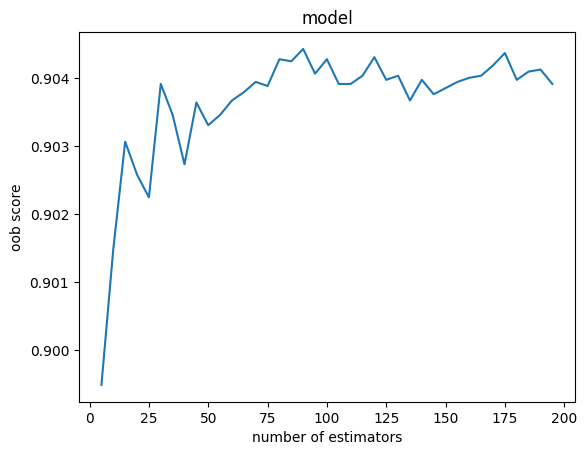

In [67]:
def graph(model, X_train, y_train):
    obb = []
    est = list(range(5, 200, 5))
    for i in tqdm(est):
        random_forest = model(n_estimators=i, criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3,)
        random_forest.fit(X_train, y_train)
        obb.append(random_forest.oob_score_)
    display('max oob {} and number of estimators {}'.format(max(obb), est[np.argmax(obb)]))
    plt.plot(est, obb)
    plt.title('model')
    plt.xlabel('number of estimators')
    plt.ylabel('oob score')
    plt.show();

graph(RandomForestClassifier, X_train, y_train)

In [68]:
''' Build graph for ROC_AUC '''

fpr, tpr, threshold = roc_curve(y_test, models[1].predict_proba(X_test)[:,1])

trace0 = go.Scatter(
    x=fpr,
    y=tpr,
    text=threshold,
    fill='tozeroy',
    name='ROC Curve')

trace1 = go.Scatter(
    x=[0,1],
    y=[0,1],
    line={'color': 'red', 'width': 1, 'dash': 'dash'},
    name='Baseline')

data = [trace0, trace1]

layout = go.Layout(
    title='ROC Curve',
    xaxis={'title': 'False Positive Rate'},
    yaxis={'title': 'True Positive Rate'})

fig = go.Figure(data, layout)
fig.show();

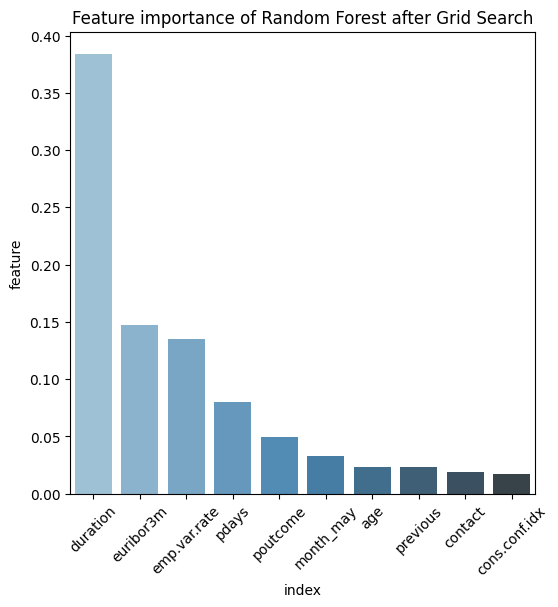

In [69]:
''' Build bar plot of feature importance of the best model '''

def build_feature_importance(model, X_train, y_train):

    models = RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, \
                           max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(X_train, y_train)
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature importance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show();

build_feature_importance(RandomForestClassifier, X_train, y_train)